In [1]:
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
plt.style.use('ggplot')
from IPython.display import Video
from IPython.display import HTML
import sys
import os
sys.path.append("..")
print(sys.path)
from settings import  DATA_DIR
import insightface
import cv2 as cv
import cv2
import matplotlib.pylab as plt
import face_recognition
from tqdm import tqdm
from PIL import Image, ImageDraw

['/home/kailu/deepfake/preprocess', '/home/kailu/.conda/envs/wukailu/lib/python37.zip', '/home/kailu/.conda/envs/wukailu/lib/python3.7', '/home/kailu/.conda/envs/wukailu/lib/python3.7/lib-dynload', '', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/googledrivedownloader-0.4-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/rdflib-4.2.2-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/plyfile-0.7.1-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/isodate-0.6.0-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/torch_geometric-1.3.2-py3.7.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/dlib-19.19.99-py3.7-linux-x86_64.egg', '/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/IPython/extensions', '/home/kailu/.ipython', '..']


In [2]:
train_dir = DATA_DIR

train_sample_metadata = pd.read_json(os.path.join(DATA_DIR,'metadata_all.json') ).T
train_sample_metadata.head()
indexes = train_sample_metadata[train_sample_metadata['label']=='REAL'].index

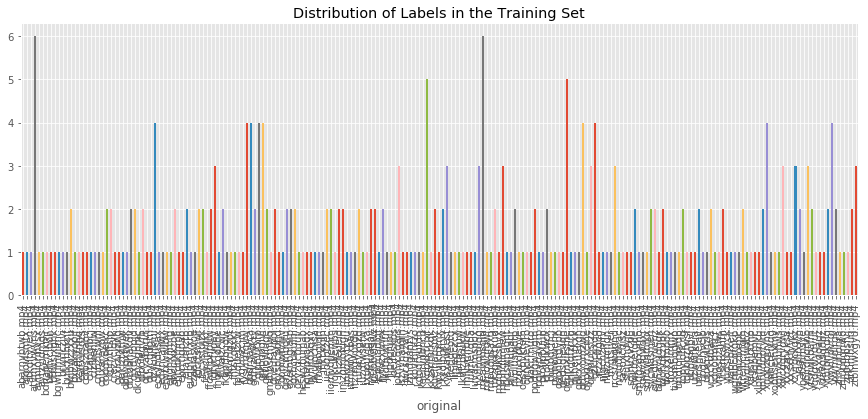

In [12]:
train_sample_metadata.groupby('original')['original'].count().plot(figsize=(15, 5), kind='bar', title='Distribution of Labels in the Training Set')
plt.show()

# Deal with the case that there's more than 1 person in the video

* 有解近20%的视频有两张及以上的脸
* 视频生成方式是一个大视频切成多个10s小视频
* fake是每次iid sample一个真10s视频进行fake
* 对于两张脸以上的假视频，每帧会随机fake其中一张脸

In [20]:
'''
[Face(bbox=array([334.43234253, 155.82444763, 559.38562012, 469.98413086]), landmark=array([[419.0745 , 281.861  ],
        [515.15594, 269.66534],
        [499.31363, 323.17172],
        [453.2359 , 398.6037 ],
        [525.49915, 388.4388 ]], dtype=float32), det_score=0.9990795850753784, 
         embedding=array([-1.0620309e+00,  1.1161977e+00,  3.8892230e-01, -2.3631424e-01,
         ...
         5.4958087e-01, -3.7592593e-01, -9.0648293e-01, -8.5524321e-02],
         dtype=float32), gender=0, age=35, embedding_norm=22.439707, 
         normed_embedding=array([-4.73282002e-02,  4.97420803e-02,  1.73318796e-02, -1.05310753e-02,
         ...
         2.44914461e-02, -1.67527106e-02, -4.03963812e-02, -3.81129398e-03],
       dtype=float32))]

left, top, right, bottom
gender = 0 -> male
embedding is gen by arcface, dist measure is cos
use f=normed_embedding, np.sum(np.square(f1 - f2))
'''
# Fex = A.get(frames[0])

'\n[Face(bbox=array([334.43234253, 155.82444763, 559.38562012, 469.98413086]), landmark=array([[419.0745 , 281.861  ],\n        [515.15594, 269.66534],\n        [499.31363, 323.17172],\n        [453.2359 , 398.6037 ],\n        [525.49915, 388.4388 ]], dtype=float32), det_score=0.9990795850753784, \n         embedding=array([-1.0620309e+00,  1.1161977e+00,  3.8892230e-01, -2.3631424e-01,\n         ...\n         5.4958087e-01, -3.7592593e-01, -9.0648293e-01, -8.5524321e-02],\n         dtype=float32), gender=0, age=35, embedding_norm=22.439707, \n         normed_embedding=array([-4.73282002e-02,  4.97420803e-02,  1.73318796e-02, -1.05310753e-02,\n         ...\n         2.44914461e-02, -1.67527106e-02, -4.03963812e-02, -3.81129398e-03],\n       dtype=float32))]\n       \ngender = 0 -> male\nembedding is gen by arcface, dist measure is cos\nuse f=normed_embedding, np.sum(np.square(f1 - f2))\n'

# a trival split

In [56]:
def dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def get_face_sub(index, emb_frames, gpu_id, process_id, face_detector, one_only = True):
    print("process id: ", process_id, "index :" , index)
    A = face_detector

    id2faces = dict()
    for fn in tqdm(index):
        label = train_sample_metadata.loc[fn]['label']
        orig = train_sample_metadata.loc[fn]['label']
        video_file = os.path.join(train_dir, fn)
        cap = cv.VideoCapture(video_file)

        frames = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret==True:
                frames.append(frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cap.release()

        frame2faces = dict()
        for j in range(0, len(frames), emb_frames): # find face in one frame
            h, w = frames[j].shape[:2]
            frame = cv2.resize(frames[j], (w//2, h//2))
            face_list = A.get(frame)
            if len(face_list) == 0:
                print(f'Could not find face in frame {j} of {fn}')
                continue
            for idx, face in enumerate(face_list):
                face_list[idx] = face_list[idx]._replace(bbox = face_list[idx].bbox*2)._asdict()
            frame2faces[j]=face_list
            if one_only:
                break
        
        id2faces[fn] = frame2faces
    
    print(id2faces)
    return id2faces

def get_face_list(index, emb_frames = 10, gpu_id = -1):
    A = insightface.app.FaceAnalysis()
    A.prepare(gpu_id)
    return get_face_sub(index, emb_frames, gpu_id, 0, A)

get_face_list(indexes[:10], gpu_id = -1, emb_frames = 10)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


  0%|          | 0/10 [00:00<?, ?it/s]

process id:  0 index : Index(['aayrffkzxn.mp4', 'apedduehoy.mp4', 'apvzjkvnwn.mp4', 'chqqxfuuzi.mp4',
       'ddtbarpcgo.mp4', 'dhjnjkzuhq.mp4', 'didzujjhtg.mp4', 'doniqevxeg.mp4',
       'dpevefkefv.mp4', 'dxfdovivlw.mp4'],
      dtype='object')


 70%|███████   | 7/10 [00:33<00:14,  4.69s/it]

KeyboardInterrupt: 

In [30]:

# temp = get_face_list_parall(train_sample_metadata[train_sample_metadata['label']=='REAL'].index[:2], gpu_ids = [0])
# temp = get_face_list(train_sample_metadata.index[1:2], gpu_id = -1, emb_frames = 10)
temp = get_face_list(indexes, gpu_id = 0, emb_frames = 15)

process id:  0 index : Index(['aayrffkzxn.mp4', 'apedduehoy.mp4', 'apvzjkvnwn.mp4', 'chqqxfuuzi.mp4',
       'ddtbarpcgo.mp4', 'dhjnjkzuhq.mp4', 'didzujjhtg.mp4', 'doniqevxeg.mp4',
       'dpevefkefv.mp4', 'dxfdovivlw.mp4',
       ...
       'znckxsojok.mp4', 'zpgqjxivpx.mp4', 'zpxirfbfiw.mp4', 'zpzycmsaik.mp4',
       'zsvfzkpjur.mp4', 'zuduvanawx.mp4', 'zwqdszjdop.mp4', 'zxafputanf.mp4',
       'zyeaapjwyg.mp4', 'zylribcaeu.mp4'],
      dtype='object', length=19154)
[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


  2%|▏         | 302/19154 [10:21<9:58:58,  1.91s/it] 

Could not find face in frame 0 of nawtezpgnm.mp4


 16%|█▌        | 3039/19154 [1:34:46<8:17:00,  1.85s/it] 

Could not find face in frame 0 of lqxpsrkxzr.mp4
Could not find face in frame 15 of lqxpsrkxzr.mp4


 19%|█▉        | 3713/19154 [1:55:34<6:59:41,  1.63s/it]

Could not find face in frame 0 of iiuqymzjbp.mp4


 20%|██        | 3846/19154 [1:59:15<6:58:28,  1.64s/it]

Could not find face in frame 0 of qpmovegayu.mp4
Could not find face in frame 15 of qpmovegayu.mp4
Could not find face in frame 30 of qpmovegayu.mp4
Could not find face in frame 45 of qpmovegayu.mp4
Could not find face in frame 60 of qpmovegayu.mp4
Could not find face in frame 75 of qpmovegayu.mp4


 20%|██        | 3847/19154 [1:59:17<7:46:36,  1.83s/it]

Could not find face in frame 90 of qpmovegayu.mp4
Could not find face in frame 105 of qpmovegayu.mp4
Could not find face in frame 120 of qpmovegayu.mp4


 24%|██▍       | 4623/19154 [2:23:28<7:51:18,  1.95s/it]

Could not find face in frame 0 of spcowtjevh.mp4


 36%|███▌      | 6908/19154 [3:36:17<6:20:04,  1.86s/it] 

Could not find face in frame 0 of jwerbdhrmu.mp4
Could not find face in frame 15 of jwerbdhrmu.mp4
Could not find face in frame 30 of jwerbdhrmu.mp4
Could not find face in frame 45 of jwerbdhrmu.mp4
Could not find face in frame 60 of jwerbdhrmu.mp4
Could not find face in frame 75 of jwerbdhrmu.mp4
Could not find face in frame 90 of jwerbdhrmu.mp4
Could not find face in frame 105 of jwerbdhrmu.mp4
Could not find face in frame 120 of jwerbdhrmu.mp4
Could not find face in frame 135 of jwerbdhrmu.mp4
Could not find face in frame 150 of jwerbdhrmu.mp4
Could not find face in frame 165 of jwerbdhrmu.mp4
Could not find face in frame 180 of jwerbdhrmu.mp4
Could not find face in frame 195 of jwerbdhrmu.mp4
Could not find face in frame 210 of jwerbdhrmu.mp4
Could not find face in frame 225 of jwerbdhrmu.mp4
Could not find face in frame 240 of jwerbdhrmu.mp4
Could not find face in frame 255 of jwerbdhrmu.mp4


 36%|███▌      | 6909/19154 [3:36:20<7:10:56,  2.11s/it]

Could not find face in frame 270 of jwerbdhrmu.mp4
Could not find face in frame 285 of jwerbdhrmu.mp4


 37%|███▋      | 7003/19154 [3:39:20<6:39:47,  1.97s/it]

Could not find face in frame 0 of rcfnkwtthd.mp4
Could not find face in frame 15 of rcfnkwtthd.mp4
Could not find face in frame 30 of rcfnkwtthd.mp4


 40%|████      | 7684/19154 [4:01:09<6:08:01,  1.93s/it]

Could not find face in frame 0 of eveuugilki.mp4
Could not find face in frame 15 of eveuugilki.mp4
Could not find face in frame 30 of eveuugilki.mp4


 40%|████      | 7687/19154 [4:01:15<6:07:04,  1.92s/it]

Could not find face in frame 0 of fdtmtbbbab.mp4
Could not find face in frame 15 of fdtmtbbbab.mp4
Could not find face in frame 30 of fdtmtbbbab.mp4
Could not find face in frame 45 of fdtmtbbbab.mp4


 41%|████      | 7796/19154 [4:04:50<6:04:34,  1.93s/it]

Could not find face in frame 0 of mcmiyabubr.mp4
Could not find face in frame 15 of mcmiyabubr.mp4


 42%|████▏     | 8082/19154 [4:14:22<6:05:14,  1.98s/it]

Could not find face in frame 0 of cibyknwzog.mp4
Could not find face in frame 15 of cibyknwzog.mp4


 43%|████▎     | 8190/19154 [4:17:50<6:12:02,  2.04s/it]

Could not find face in frame 0 of jcjvaypgbq.mp4
Could not find face in frame 15 of jcjvaypgbq.mp4


 44%|████▎     | 8340/19154 [4:22:40<5:55:20,  1.97s/it]

Could not find face in frame 0 of sqsokfhyia.mp4


 47%|████▋     | 8922/19154 [4:41:18<5:26:06,  1.91s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 93%|█████████▎| 17858/19154 [9:29:29<43:22,  2.01s/it]

Could not find face in frame 0 of dpjzcvczif.mp4
Could not find face in frame 15 of dpjzcvczif.mp4
Could not find face in frame 30 of dpjzcvczif.mp4
Could not find face in frame 45 of dpjzcvczif.mp4


 93%|█████████▎| 17861/19154 [9:29:35<42:06,  1.95s/it]

Could not find face in frame 0 of drsfrhpdgk.mp4
Could not find face in frame 15 of drsfrhpdgk.mp4
Could not find face in frame 30 of drsfrhpdgk.mp4
Could not find face in frame 45 of drsfrhpdgk.mp4
Could not find face in frame 60 of drsfrhpdgk.mp4
Could not find face in frame 75 of drsfrhpdgk.mp4
Could not find face in frame 90 of drsfrhpdgk.mp4
Could not find face in frame 105 of drsfrhpdgk.mp4
Could not find face in frame 120 of drsfrhpdgk.mp4
Could not find face in frame 135 of drsfrhpdgk.mp4
Could not find face in frame 150 of drsfrhpdgk.mp4
Could not find face in frame 165 of drsfrhpdgk.mp4


 96%|█████████▋| 18470/19154 [9:49:07<19:24,  1.70s/it]

Could not find face in frame 0 of phjevxqkxu.mp4


100%|██████████| 19154/19154 [10:09:29<00:00,  1.71s/it]


In [32]:
import pickle
save_path = "/home/kailu/deepfake/preprocess/face_info_list.pkl"
with open(save_path, 'wb') as handle:
    pickle.dump(temp, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(save_path, 'rb') as file:
    temp = pickle.load(file)

# Clustering

In [5]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import namedtuple

FaceinFrame = namedtuple("FaceinFrame", ['face_feature', 'file_name', 'frame_index', 'face_index'])

face_list = [FaceinFrame(face, fn, fid, t) for fn,face_dict in temp.items() for fid,face_list in face_dict.items() for t,face in enumerate(face_list)]
X = np.array([face.face_feature['normed_embedding'] for face in face_list])
print(X.shape)


n_clusters = 2200
estimator = KMeans(n_clusters=n_clusters)#这个参数要二分一下
estimator.fit(X)
label_pred = estimator.labels_ 
centers = estimator.cluster_centers_
print("inertia:", estimator.inertia_)

max_dis_from_center = 0
for i in range(len(centers)):
    max_dis_from_center = max(max_dis_from_center, dist(centers[label_pred[i]], X[i]))
print("maxdis:", max_dis_from_center) #0.6753322

# Y = TSNE(init='pca').fit_transform(X)

# fig, axes = plt.subplots(1, 1, figsize=(15, 15))
# axes = np.array(axes)
# axes = axes.reshape(-1)
# color = label_pred
# plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)

# plt.show()

maxdis: 0.82604814


In [7]:
df2 = pd.DataFrame({(f.file_name, f.face_index):[label_pred[i], f.frame_index, f.face_feature] for i,f in enumerate(face_list)}, index = ['class','frame','face_feature']).T
print(len(df2.xs(0, level=1)), len(indexes))
print(df2.head())

NameError: name 'indexes' is not defined

# visualize captured face

In [16]:
# 怎么还有竖着的视频
from insightface.app.face_analysis import  Face

def show_faces(dataframe):
    # only show first 90
    rows = min(30, (len(dataframe)+2)//3)
    fig, axes = plt.subplots(rows , 3, figsize=(15, rows*5))
    axes = np.array(axes)
    axes = axes.reshape(-1)

    padding = 60
    ax_ix = 0

    for fn, face_index in tqdm(dataframe.index):
        video_file = os.path.join(train_dir, fn)
        cap = cv.VideoCapture(video_file)
        
        frame_index = dataframe.at[(fn, face_index), 'frame']
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  #设置要获取的帧号
        _, frame=cap.read()
        if _ == False:
            print("Reading Failed at " + fn)
        cap.release()
        
        face = dataframe.at[(fn, face_index), 'face_feature']
        
        left, top, right, bottom = face['bbox']astype(int)
        frame_face = frame[max(0,top-padding):bottom+padding, max(0,left-padding):right+padding]
                
        image = cv.cvtColor(frame_face, cv.COLOR_BGR2RGB)
        axes[ax_ix].imshow(image)
        axes[ax_ix].xaxis.set_visible(False)
        axes[ax_ix].yaxis.set_visible(False)
        axes[ax_ix].set_title(fn)
        ax_ix += 1
        if ax_ix >= 90:
            break


    plt.grid(False)
    plt.show()
    
def show_faces2(dataframe):
    rows = min(30, (len(dataframe)+2)//3)
    fig, axes = plt.subplots(rows , 3, figsize=(15, rows*5))
    axes = np.array(axes)
    axes = axes.reshape(-1)

    padding = 60
    ax_ix = 0

    for fn, frame_index, face_index in tqdm(dataframe.index):
        video_file = os.path.join(train_dir, fn)
        cap = cv.VideoCapture(video_file)
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  #设置要获取的帧号
        _, frame=cap.read()
        if _ == False:
            print("Reading Failed at " + fn)
        cap.release()
        
        left, top, right, bottom = dataframe.at[(fn, frame_index, face_index), 'bbox'].astype(int)
        frame_face = frame[top:bottom, left:right]
#         frame_face = frame
                
        image = cv.cvtColor(frame_face, cv.COLOR_BGR2RGB)
        axes[ax_ix].imshow(image)
        axes[ax_ix].xaxis.set_visible(False)
        axes[ax_ix].yaxis.set_visible(False)
        axes[ax_ix].set_title(fn)
        ax_ix += 1
        if ax_ix >= 90:
            break


    plt.grid(False)
    plt.show()


100%|██████████| 14/14 [00:03<00:00,  4.63it/s]


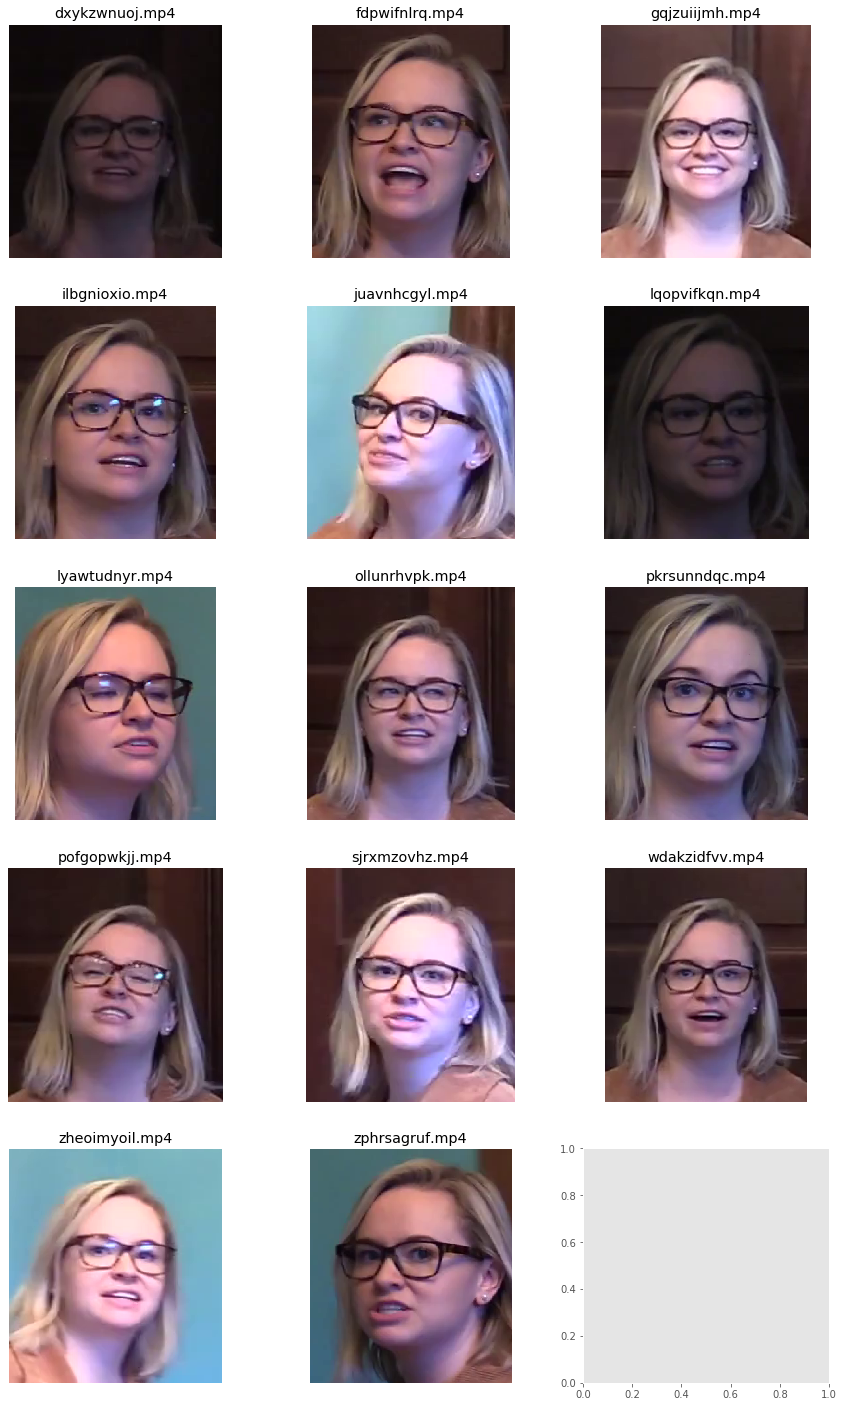

In [49]:
show_faces(df2[df2['class']==2020])

In [11]:
indexes2 = df2.xs(0, level=1).index.get_level_values(0)
for idx in indexes:
    if idx not in indexes2:
        print(idx," is dropped")

jwerbdhrmu.mp4  is dropped
mxuviiuuks.mp4  is dropped
qhgatctqbg.mp4  is dropped


In [14]:
father = [0]*len(nodes)     # 记录父节点

def ff(v):
    if father[v]==v:
        return v
    father[v] = ff(father[v])
    return father[v]

def union_find(nodes, edges):

    for node in nodes:  # 初始化为本身
        father[node] = node
 
    for edge in edges:  # 标记父节点
        if ff(edge[0]) == ff(edge[1]):
            continue
        father[ff(edge[0])] = ff(edge[1])
 
    for node in nodes:
        father[node] = ff(node)
 
    L = {}
    for i, f in enumerate(father):
        L[f] = []
    for i, f in enumerate(father):
        L[f].append(i)
 
    return L


nodes = list(range(0, n_clusters))
edges = []

for fn in indexes2:
    tempdf = df2.xs(fn, level=0)
    if len(tempdf)>1:
        classes = list(set(tempdf['class']))
        for i in range(len(classes)-1):
            edges.append([classes[i],classes[i+1]])

L = union_find(nodes, edges)
print('num of classes:', len(L))

num of classes: 1557


In [15]:
union_anc = {}
for fa,i in L.items():
    for class_id in i:
        union_anc[class_id]=fa
df2['union_anc'] = df2['class'].apply(lambda x: union_anc[x])


100%|██████████| 62/62 [00:13<00:00,  4.99it/s]


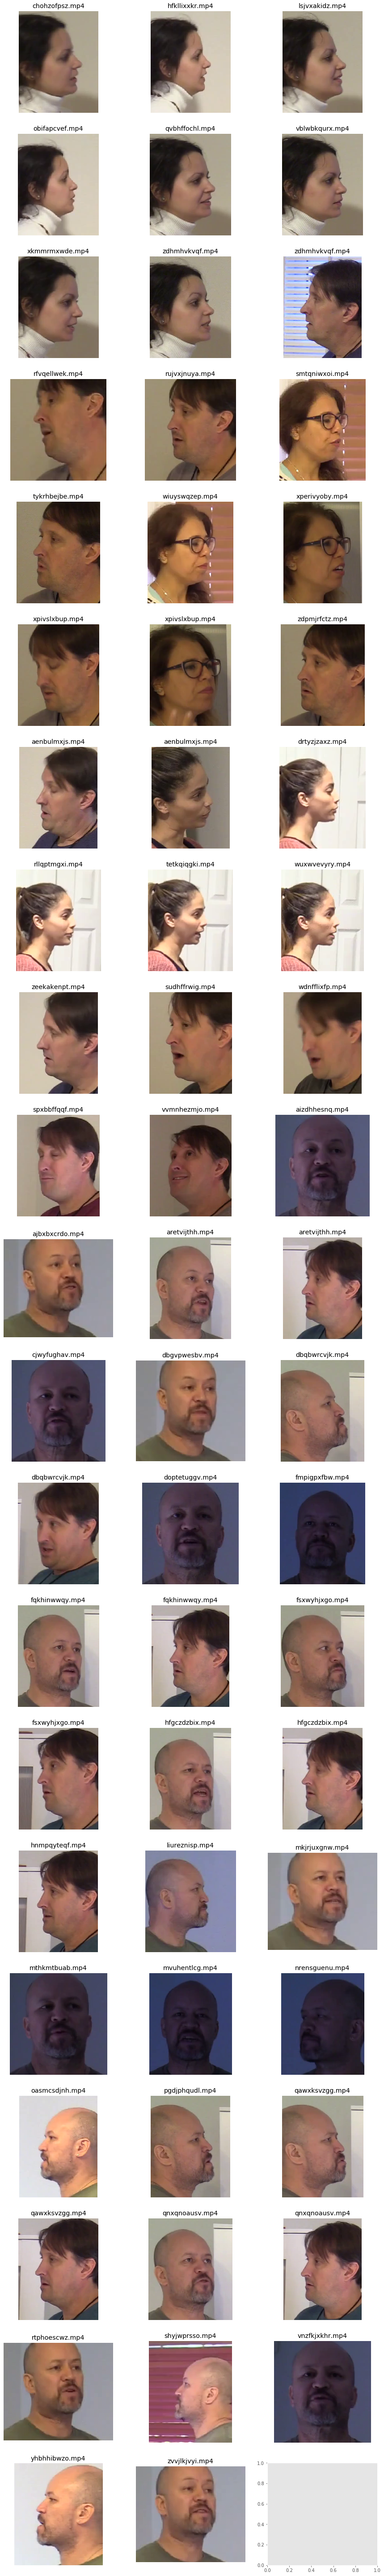

In [61]:
# 我靠还真TM有 A和B聊天，B和C聊天，C和D聊天
show_faces(df2[df2['union_anc']==1410])

# train, test, validation split

In [16]:
splits = {}
for i in L.values():
    split = np.random.rand()
    if split < 0.8:
        split = 'train'
    elif split < 0.9:
        split = 'validation'
    else:
        split = 'test'
    for class_id in i:
        splits[class_id]=split
df2['split'] = df2['class'].apply(lambda x: splits[x])

In [17]:
print(len(df2[df2['split']=='train']))
print(len(df2[df2['split']=='validation']))
print(len(df2[df2['split']=='test']))

16326
2292
2221


In [18]:
def get_split(row):
    if row.label == 'REAL':
        if row.name not in indexes2:
            return -1
        return df2.at[(row.name,0),'split']
    else:
        try:
            return df2.at[(row.original,0),'split']
        except:
            return -1
train_sample_metadata['split_kailu'] = train_sample_metadata.apply(get_split, axis=1)

In [19]:
def get_person(row):
    name = row.name
    if row.label == 'FAKE':
        name = row.original
    if name not in indexes2:
            return -1
    return len(df2.xs(name, level=0))
train_sample_metadata['person_num'] = train_sample_metadata.apply(get_person, axis=1)

In [20]:
df2.to_csv('df2.csv')
train_sample_metadata.T.to_json('metadata_kailu.json')

In [29]:
!sudo cp metadata_kailu.json /data1/data/deepfake/dfdc_train/

[sudo] password for kailu: 


# Other stuff

# 几个由于数据不均衡导致的问题和BUG

* 训练集中负例太多且多样，而正例的脸就那么一点，一个脸作为正例太多，可能被记住
* 同理测试集中，目前划分还是不均衡的，所以需要随机删除75%的负例，然而正例过少且不能删，所以不少正例脸会是一样的，导致测试结果不一定稳定
* LB中，暂不明确数据生成方式，只知道正负例均衡，但目前猜测到两个可以利用的BUG
* 如果LB中对于同一个人的10s视频出现了多个，且对应的负例生成采用每个10s单独生成。那么根据视频背景环境聚类，然后再取人脸特征的众数，就是真实脸的特征。
* 如果LB中对于同一个人的多个10s视频，全都fake到另外同一个人脸上，那么对于视频背景聚类后，应该根据人脸特征可以划分成两个大类，而其中fake的一类只要有一个视频出现明显合成错误（似乎在人物脸部倾斜角度稍大的情况下，fake出来效果糟糕），则可以推出全部都是假的。
* 一些额外内容，我们需要极为高效的人脸bounding box算法和人脸特征提取算法

In [72]:
train_sample_metadata[train_sample_metadata['label']=='REAL'].head()

label original  split split_kailu
aayrffkzxn.mp4  REAL     None  train       train
apedduehoy.mp4  REAL     None  train       train
apvzjkvnwn.mp4  REAL     None  train  validation
chqqxfuuzi.mp4  REAL     None  train       train
ddtbarpcgo.mp4  REAL     None  train       train

In [74]:
train_sample_metadata[train_sample_metadata['original']=='apvzjkvnwn.mp4']

label        original  split split_kailu
augowetyej.mp4  FAKE  apvzjkvnwn.mp4  train  validation
axbvoepbdc.mp4  FAKE  apvzjkvnwn.mp4  train  validation
cxjtjcinqt.mp4  FAKE  apvzjkvnwn.mp4  train  validation
gczieafvpe.mp4  FAKE  apvzjkvnwn.mp4  train  validation
jeosukfzow.mp4  FAKE  apvzjkvnwn.mp4  train  validation
kanuhxwqaa.mp4  FAKE  apvzjkvnwn.mp4  train  validation
nbibouebku.mp4  FAKE  apvzjkvnwn.mp4  train  validation
qjsroipniu.mp4  FAKE  apvzjkvnwn.mp4  train  validation
qmmzklpowl.mp4  FAKE  apvzjkvnwn.mp4  train  validation
vrceadqnhq.mp4  FAKE  apvzjkvnwn.mp4  train  validation
xjpwlxducl.mp4  FAKE  apvzjkvnwn.mp4  train  validation

In [28]:
train_sample_metadata[train_sample_metadata['person_num']>4]

label        original  split split_kailu  person_num
cacdswmrdp.mp4  REAL            None  train       train           5
gtawaprccv.mp4  FAKE  cacdswmrdp.mp4  train       train           5
mccibfjkqx.mp4  FAKE  cacdswmrdp.mp4  train       train           5
mlcdfxfbhd.mp4  FAKE  cacdswmrdp.mp4  train       train           5
negnavupsk.mp4  FAKE  cacdswmrdp.mp4  train       train           5
xilquenqtd.mp4  FAKE  cacdswmrdp.mp4  train       train           5

In [21]:
df2.head()

class frame  \
aayrffkzxn.mp4 0   896     0   
apedduehoy.mp4 0   191     0   
apvzjkvnwn.mp4 0   450     0   
chqqxfuuzi.mp4 0   191     0   
ddtbarpcgo.mp4 0   763     0   

                                                       face_feature  \
aayrffkzxn.mp4 0  ([515.6837158203125, 457.1701965332031, 762.01...   
apedduehoy.mp4 0  ([533.0321044921875, 36.80067825317383, 717.61...   
apvzjkvnwn.mp4 0  ([976.5567016601562, 278.0755310058594, 1213.2...   
chqqxfuuzi.mp4 0  ([449.8432312011719, 313.4251403808594, 610.54...   
ddtbarpcgo.mp4 0  ([451.9956359863281, 877.928466796875, 557.519...   

                  union_anc       split  
aayrffkzxn.mp4 0        896        test  
apedduehoy.mp4 0        191  validation  
apvzjkvnwn.mp4 0        450       train  
chqqxfuuzi.mp4 0        191  validation  
ddtbarpcgo.mp4 0        763       train

# 避开生成数据过程BUG的训练方式

* 方案1，抛开时序，建立时序无关模型，每次每个视频取一帧，drop掉多个人脸的fake数据，找到人脸bbox，向外扩30px，调整到256 * 256 然后每次随机crop 112 * 112的范围，作为一张图片给网络训练。
* 对于多个人fake，利用每次只fake一张脸进行识别。

# Generate BBox in Parrall

In [6]:
import dlib
from multiprocessing import  Pool

    
def get_boundingbox(bbox, width, height, scale=1.2, minsize=None):
    x1, y1, x2, y2 = bbox[:4]
    size_bb = int(max(x2 - x1, y2 - y1) * scale)
    if minsize:
        if size_bb < minsize:
            size_bb = minsize
    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2

    # Check for out of bounds, x-y top left corner
    x1 = max(int(center_x - size_bb / 2), 0)
    y1 = max(int(center_y - size_bb / 2), 0)
    # Check for too big bb size for given x, y
    size_bb = min(width - x1, size_bb)
    size_bb = min(height - y1, size_bb)

    return x1, y1, size_bb

def get_bbox(face_detector, img, engine = 'dlib'):
    if engine == 'dlib':
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray, 0)
        bboxes = [[face.left(), face.top(), face.right(), face.bottom()] for face in faces]
    elif engine == 'mtcnn':
        bboxes, landmarks = face_detector.detect(img, threshold=0.8, scale = 1)

    height, width = img.shape[:2]

    ret_bbox = []
    for box in bboxes:
        x, y, size = get_boundingbox(box, width, height)
        ret_bbox.append(np.array([x,y,x+size,y+size]))
    return ret_bbox
    
def get_bbox_sub(index, emb_frames, face_detector, process_id, engine = 'dlib'):
    print("process id: ", process_id, "index :" , index)
    if engine == 'mtcnn':
        face_detector.prepare(process_id, 0.4)
    
    id2bbox = dict()
    for fn in tqdm(index):
#         try:
        label = train_sample_metadata.loc[fn]['label']
        video_file = os.path.join(train_dir, fn)
        cap = cv.VideoCapture(video_file)

        frames = []
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret==True:
                frames.append(frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cap.release()

        frame2bbox = dict()
        hasface = False
        for j in range(0, len(frames), emb_frames): # find face in one frame
            bbox_list = get_bbox(face_detector, frames[j], engine = engine)

            if len(bbox_list) == 0:
                continue
            hasface = True
            frame2bbox[j]=bbox_list
        if not hasface:
            print(f'Could not find face in frame {fn}')

        id2bbox[fn] = frame2bbox
#         except:
#             REMSG = "Runtime Error! on " + fn
#             print(REMSG)
    return id2bbox    


def get_bbox_parall(index, emb_frames = 150, gpu_ids = [-1]):
    pool = Pool(processes = len(gpu_ids))
    rets = []
    
    index_per_GPU = len(index)//len(gpu_ids)
    for i, gpu in enumerate(gpu_ids):
#         face_detector = dlib.get_frontal_face_detector()
        face_detector = insightface.model_zoo.model_zoo.get_model('retinaface_r50_v1')
        sub_index = index[i*index_per_GPU:(i+1)*index_per_GPU] if i+1 < len(gpu_ids) else index[i*index_per_GPU:]
        ret = pool.apply_async(get_bbox_sub, (sub_index, emb_frames, face_detector, gpu, 'mtcnn'))
        rets.append(ret)
    
    pool.close()
    pool.join()
    
    id2faces = dict()
    for ret in rets:
        id2faces_sub = ret.get()
        print(len(id2faces_sub))
        id2faces.update(id2faces_sub)
    return id2faces


# get_bbox_parall(indexes[:3], emb_frames = 100, gpu_ids = list(range(1)))

# face_detector = insightface.model_zoo.model_zoo.get_model('retinaface_r50_v1')
# id2faces = get_bbox_sub(indexes[:2], 100, face_detector, 0, 'mtcnn')

In [7]:
id2faces = get_bbox_parall(indexes, emb_frames = 10, gpu_ids = [-1, -1, -1, -1])

process id:  -1 index : Index(['aayrffkzxn.mp4', 'apedduehoy.mp4', 'apvzjkvnwn.mp4', 'chqqxfuuzi.mp4',
       'ddtbarpcgo.mp4', 'dhjnjkzuhq.mp4', 'didzujjhtg.mp4', 'doniqevxeg.mp4',
       'dpevefkefv.mp4', 'dxfdovivlw.mp4',
       ...
       'calmewskjn.mp4', 'cbobaygolx.mp4', 'cbxvjlttcp.mp4', 'ccpwvuudgy.mp4',
       'cdtgayygwn.mp4', 'cdynaiiotj.mp4', 'cflkoqmenk.mp4', 'chpqftmhpr.mp4',
       'chwoehjcpv.mp4', 'cjgktnbbyw.mp4'],
      dtype='object', length=4788)
process id:  -1 index : Index(['ckgrpklzyd.mp4', 'clcxdmbhxf.mp4', 'clqufrsfxn.mp4', 'coilvztxsl.mp4',
       'cpylltovhq.mp4', 'cuqpcymavt.mp4', 'cwthksdnco.mp4', 'cwywmteqst.mp4',
       'dasoffaihl.mp4', 'ddpkbmwrra.mp4',
       ...
       'qvpijvpktb.mp4', 'rcsfrtqmig.mp4', 'reewxlyouf.mp4', 'rfngbcfwqt.mp4',
       'rhuvtpcucs.mp4', 'rmjfkuehpt.mp4', 'rowhhbrpup.mp4', 'rplfdwhyya.mp4',
       'rrpstiorkb.mp4', 'rsznrudrjz.mp4'],
      dtype='object', length=4788)
process id:  -1 index : Index(['rvivxbtbda.mp4', 'rvrn

  0%|          | 0/4788 [00:00<?, ?it/s]

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


  0%|          | 0/4788 [00:00<?, ?it/s]

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


  0%|          | 0/4788 [00:00<?, ?it/s]

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


  2%|▏         | 98/4788 [10:58:11<516:22:27, 396.36s/it]]

KeyboardInterrupt: 

Process ForkPoolWorker-6:
Traceback (most recent call last):
  File "/home/kailu/.conda/envs/wukailu/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/kailu/.conda/envs/wukailu/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/kailu/.conda/envs/wukailu/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "<ipython-input-6-83811f57f2aa>", line 64, in get_bbox_sub
    bbox_list = get_bbox(face_detector, frames[j], engine = engine)
  File "<ipython-input-6-83811f57f2aa>", line 28, in get_bbox
    bboxes, landmarks = face_detector.detect(img, threshold=0.8, scale = 1)
  File "/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/insightface/model_zoo/face_detection.py", line 303, in detect
    scores = net_out[idx].asnumpy()
  File "/home/kailu/.conda/envs/wukailu/lib/python3.7/site-packages/mxnet/ndarray/ndarray.py"

In [26]:
dfbox = pd.DataFrame({(file_name, frame, fid):[bbox] for file_name,data in id2faces.items() for frame, bboxes in data.items() for fid, bbox in enumerate(bboxes)}, index = ['bbox']).T
print(len(dfbox))
dfbox.head()

513771


bbox
aayrffkzxn.mp4 10 0   [498, 545, 756, 803]
               30 0   [378, 665, 636, 923]
               40 0   [354, 736, 612, 994]
               50 0  [355, 813, 569, 1027]
               80 0  [255, 832, 471, 1048]

100%|██████████| 10/10 [00:03<00:00,  3.21it/s]


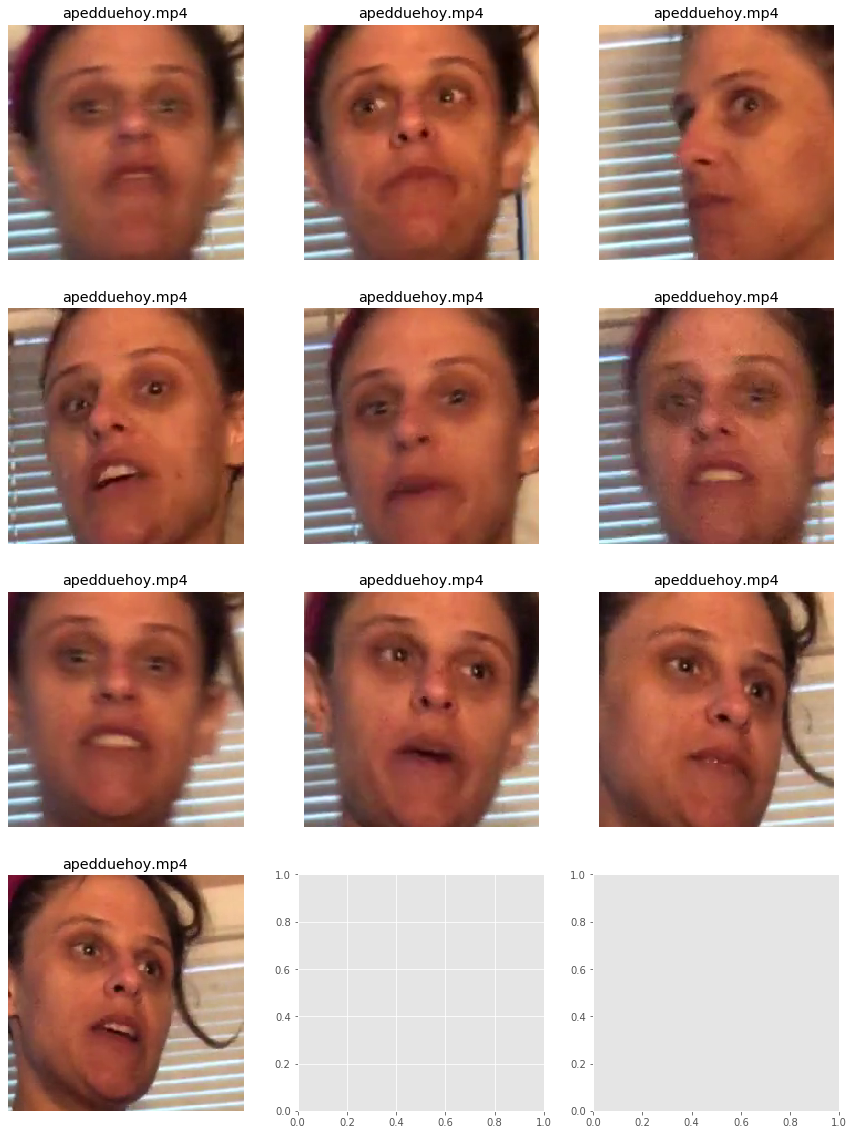

In [25]:
show_faces2(dfbox[30:40])

In [27]:
dfbox.to_json('bbox.json')

In [55]:
def get_face_parall(index, emb_frames = 150, gpu_ids = [-1]):
    pool = Pool(processes = len(gpu_ids))
    rets = []
    
    index_per_GPU = len(index)//len(gpu_ids)
    for i, gpu in enumerate(gpu_ids):
        face_detector = insightface.app.FaceAnalysis()
        face_detector.prepare(gpu)
        sub_index = index[i*index_per_GPU:(i+1)*index_per_GPU] if i+1 < len(gpu_ids) else index[i*index_per_GPU:]
        ret = pool.apply_async(get_face_sub, (sub_index, emb_frames, gpu, i, face_detector, False))
        rets.append(ret)
    
    pool.close()
    pool.join()
    
    id2faces = dict()
    for ret in rets:
        id2faces_sub = ret.get()
        print(len(id2faces_sub))
        id2faces.update(id2faces_sub)
    return id2faces

id2faces2 = get_face_parall(indexes[:2], emb_frames = 100, gpu_ids = [-1]*1)

[32, 16, 8] {'32': {'SCALES': (32, 16), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '16': {'SCALES': (8, 4), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}, '8': {'SCALES': (2, 1), 'BASE_SIZE': 16, 'RATIOS': (1.0,), 'ALLOWED_BORDER': 9999}}
use_landmarks True


TypeError: can't pickle module objects

# Estimate Var and Mean

In [43]:
def get_mean_var(dataframe):

    all_imgs = []
    for fn, frame_index, face_index in tqdm(dataframe.sample(n=10000).index):
        video_file = os.path.join(train_dir, fn)
        cap = cv.VideoCapture(video_file)
        
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)  #设置要获取的帧号
        _, frame=cap.read()
        if _ == False:
            print("Reading Failed at " + fn)
        cap.release()
        
        left, top, right, bottom = dataframe.at[(fn, frame_index, face_index), 'bbox'].astype(int)
        frame_face = frame[top:bottom, left:right]
                
        image = cv.cvtColor(frame_face, cv.COLOR_BGR2RGB)
        image = cv.resize(image, (224, 224))/255
        all_imgs.append(image)
    
    all_imgs = np.stack(all_imgs)
    print(f"mean: [{np.mean(all_imgs[:,:,:,0])},{np.mean(all_imgs[:,:,:,1])},{np.mean(all_imgs[:,:,:,2])}]")
    print(f"std: [{np.std(all_imgs[:,:,:,0])},{np.std(all_imgs[:,:,:,1])},{np.std(all_imgs[:,:,:,2])}]")
    
get_mean_var(dfbox[:])

100%|██████████| 10000/10000 [48:42<00:00,  3.47it/s] 


mean: [0.4294808522471488,0.3224705249287213,0.3000745109684491]
var: [0.05160604490603585,0.04140944845817726,0.039261207536230004]
